In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource
from ipywidgets import interact

In [3]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
covid_deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
covid_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
covid_recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [5]:
covid_deaths_df.head(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22,22,27,29
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
covid_confirmed_df.head(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266


Well, that doesn't make sense. The number of confirmed cases in Cook County, IL drops from 7 to 0 on 3/10. 

In [7]:
covid_confirmed_df.loc[covid_confirmed_df['Province/State'].str.contains('Cook County, IL', na=False)]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
348,"Cook County, IL",US,41.7377,-87.6976,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,4,4,4,5,5,6,7,7,0,0,0,0,0,0,0,0


In [8]:
covid_recovered_df.head(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35,35,35,41
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118,118,144,144
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105,105,109,114


In [9]:
def preprocess_covid_data(df=covid_deaths_df):
    df=df.copy()
    df['location'] = df.apply(lambda x: f"{x['Province/State']}, {x['Country/Region']}" if pd.notnull(x['Province/State']) else x['Country/Region'], axis=1)
    locations_df = df[['location', 'Lat', 'Long']].copy()
    df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1, inplace=True)
    df.set_index('location', inplace=True)
    df.index.name = None
    df = df.T
    df.reset_index(inplace=True)
    df.rename({'index':'date'}, axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
    totals_df = df[[col for col in df.columns if col != 'date']].copy()
    totals_df.set_index(df['date'], inplace=True)
    totals_df.reset_index(inplace=True)
    return (locations_df, totals_df)                            

In [10]:
death_locations, deaths_df = preprocess_covid_data(df=covid_deaths_df)
confirmed_locations, confirmed_df = preprocess_covid_data(df=covid_confirmed_df)
recovered_locations, recovered_df = preprocess_covid_data(df=covid_recovered_df)

In [11]:
deaths_df.tail(3)

,date,Thailand,Japan,Singapore,Nepal,Malaysia,"British Columbia, Canada","New South Wales, Australia","Victoria, Australia","Queensland, Australia",Cambodia,Sri Lanka,Germany,Finland,United Arab Emirates,Philippines,India,Italy,Sweden,Spain,"South Australia, Australia",Belgium,Egypt,"From Diamond Princess, Australia",Lebanon,Iraq,Oman,Afghanistan,Bahrain,Kuwait,Algeria,Croatia,Switzerland,Austria,Israel,Pakistan,Brazil,Georgia,Greece,North Macedonia,Norway,Romania,Estonia,San Marino,Belarus,Iceland,Lithuania,Mexico,New Zealand,Nigeria,"Western Australia, Australia",Ireland,Luxembourg,Monaco,Qatar,Ecuador,Azerbaijan,Armenia,Dominican Republic,Indonesia,Portugal,Andorra,"Tasmania, Australia",Latvia,Morocco,Saudi Arabia,Senegal,Argentina,Chile,Jordan,Ukraine,Hungary,"Northern Territory, Australia",Liechtenstein,Poland,Tunisia,Bosnia and Herzegovina,Slovenia,South Africa,Bhutan,Cameroon,Colombia,Costa Rica,Peru,Serbia,Slovakia,Togo,Malta,Martinique,Bulgaria,Maldives,Bangladesh,Paraguay,"Ontario, Canada","Alberta, Canada","Quebec, Canada",Albania,Cyprus,Brunei,"Washington, US","New York, US","California, US","Massachusetts, US","Diamond Princess, US","Grand Princess, US","Georgia, US","Colorado, US","Florida, US","New Jersey, US","Oregon, US","Texas, US","Illinois, US","Pennsylvania, US","Iowa, US","Maryland, US","North Carolina, US","South Carolina, US","Tennessee, US","Virginia, US","Arizona, US","Indiana, US","Kentucky, US","District of Columbia, US","Nevada, US","New Hampshire, US","Minnesota, US","Nebraska, US","Ohio, US","Rhode Island, US","Wisconsin, US","Connecticut, US","Hawaii, US","Oklahoma, US","Utah, US",Burkina Faso,Holy See,Mongolia,Panama,"Kansas, US","Louisiana, US","Missouri, US","Vermont, US","Alaska, US","Arkansas, US","Delaware, US","Idaho, US","Maine, US","Michigan, US","Mississippi, US","Montana, US","New Mexico, US","North Dakota, US","South Dakota, US","West Virginia, US","Wyoming, US","Hubei, China",Iran,"Korea, South","France, France","Guangdong, China","Henan, China","Zhejiang, China","Hunan, China","Anhui, China","Jiangxi, China","Shandong, China","Diamond Princess, Cruise Ship","Jiangsu, China","Chongqing, China","Sichuan, China","Heilongjiang, China","Denmark, Denmark","Beijing, China","Shanghai, China","Hebei, China","Fujian, China","Guangxi, China","Shaanxi, China","Yunnan, China","Hainan, China","Guizhou, China","Tianjin, China","Shanxi, China","Gansu, China","Hong Kong, China","Liaoning, China","Jilin, China",Czechia,"Xinjiang, China","Inner Mongolia, China","Ningxia, China",Taiwan*,Vietnam,Russia,"Qinghai, China","Macau, China",Moldova,Bolivia,"Faroe Islands, Denmark","St Martin, France",Honduras,"Channel Islands, United Kingdom","New Brunswick, Canada","Tibet, China",Congo (Kinshasa),Cote d'Ivoire,"Saint Barthelemy, France",Jamaica,Turkey,"Gibraltar, United Kingdom","Kitsap, WA, US","Solano, CA, US","Santa Cruz, CA, US","Napa, CA, US","Ventura, CA, US","Worcester, MA, US","Gwinnett, GA, US","DeKalb, GA, US","Floyd, GA, US","Fayette, GA, US","Gregg, TX, US","Monmouth, NJ, US","Burlington, NJ, US","Camden, NJ, US","Passaic, NJ, US","Union, NJ, US","Eagle, CO, US","Larimer, CO, US","Arapahoe, CO, US","Gunnison, CO, US","Kane, IL, US","Monroe, PA, US","Philadelphia, PA, US","Norfolk, VA, US","Arlington, VA, US","Spotsylvania, VA, US","Loudoun, VA, US","Prince George's, MD, US","Pottawattamie, IA, US","Camden, NC, US","Pima, AZ, US","Noble, IN, US","Adams, IN, US","Boone, IN, US","Dane, WI, US","Pierce, WI, US","Cuyahoga, OH, US","Weber, UT, US","Bennington County, VT, US","Carver County, MN, US","Charlotte County, FL, US","Cherokee County, GA, US","Collin County, TX, US","Jefferson County, KY, US","Jefferson Parish, LA, US","Shasta County, CA, US","Spartanburg County, SC, US","Harrison County, KY, US","Johnson County, IA, US","Berkshire County, MA, US","Davidson County, TN, US","Douglas County, OR, US","Fresno County, CA, US","Harford County, MD, US","Hendricks County, IN, US","Hudson County, NJ, US

In [12]:
confirmed_df.tail(3)

,date,Thailand,Japan,Singapore,Nepal,Malaysia,"British Columbia, Canada","New South Wales, Australia","Victoria, Australia","Queensland, Australia",Cambodia,Sri Lanka,Germany,Finland,United Arab Emirates,Philippines,India,Italy,Sweden,Spain,"South Australia, Australia",Belgium,Egypt,"From Diamond Princess, Australia",Lebanon,Iraq,Oman,Afghanistan,Bahrain,Kuwait,Algeria,Croatia,Switzerland,Austria,Israel,Pakistan,Brazil,Georgia,Greece,North Macedonia,Norway,Romania,Estonia,San Marino,Belarus,Iceland,Lithuania,Mexico,New Zealand,Nigeria,"Western Australia, Australia",Ireland,Luxembourg,Monaco,Qatar,Ecuador,Azerbaijan,Armenia,Dominican Republic,Indonesia,Portugal,Andorra,"Tasmania, Australia",Latvia,Morocco,Saudi Arabia,Senegal,Argentina,Chile,Jordan,Ukraine,Hungary,"Northern Territory, Australia",Liechtenstein,Poland,Tunisia,Bosnia and Herzegovina,Slovenia,South Africa,Bhutan,Cameroon,Colombia,Costa Rica,Peru,Serbia,Slovakia,Togo,Malta,Martinique,Bulgaria,Maldives,Bangladesh,Paraguay,"Ontario, Canada","Alberta, Canada","Quebec, Canada",Albania,Cyprus,Brunei,"Washington, US","New York, US","California, US","Massachusetts, US","Diamond Princess, US","Grand Princess, US","Georgia, US","Colorado, US","Florida, US","New Jersey, US","Oregon, US","Texas, US","Illinois, US","Pennsylvania, US","Iowa, US","Maryland, US","North Carolina, US","South Carolina, US","Tennessee, US","Virginia, US","Arizona, US","Indiana, US","Kentucky, US","District of Columbia, US","Nevada, US","New Hampshire, US","Minnesota, US","Nebraska, US","Ohio, US","Rhode Island, US","Wisconsin, US","Connecticut, US","Hawaii, US","Oklahoma, US","Utah, US",Burkina Faso,Holy See,Mongolia,Panama,"Kansas, US","Louisiana, US","Missouri, US","Vermont, US","Alaska, US","Arkansas, US","Delaware, US","Idaho, US","Maine, US","Michigan, US","Mississippi, US","Montana, US","New Mexico, US","North Dakota, US","South Dakota, US","West Virginia, US","Wyoming, US","Hubei, China",Iran,"Korea, South","France, France","Guangdong, China","Henan, China","Zhejiang, China","Hunan, China","Anhui, China","Jiangxi, China","Shandong, China","Diamond Princess, Cruise Ship","Jiangsu, China","Chongqing, China","Sichuan, China","Heilongjiang, China","Denmark, Denmark","Beijing, China","Shanghai, China","Hebei, China","Fujian, China","Guangxi, China","Shaanxi, China","Yunnan, China","Hainan, China","Guizhou, China","Tianjin, China","Shanxi, China","Gansu, China","Hong Kong, China","Liaoning, China","Jilin, China",Czechia,"Xinjiang, China","Inner Mongolia, China","Ningxia, China",Taiwan*,Vietnam,Russia,"Qinghai, China","Macau, China",Moldova,Bolivia,"Faroe Islands, Denmark","St Martin, France",Honduras,"Channel Islands, United Kingdom","New Brunswick, Canada","Tibet, China",Congo (Kinshasa),Cote d'Ivoire,"Saint Barthelemy, France",Jamaica,Turkey,"Gibraltar, United Kingdom","Kitsap, WA, US","Solano, CA, US","Santa Cruz, CA, US","Napa, CA, US","Ventura, CA, US","Worcester, MA, US","Gwinnett, GA, US","DeKalb, GA, US","Floyd, GA, US","Fayette, GA, US","Gregg, TX, US","Monmouth, NJ, US","Burlington, NJ, US","Camden, NJ, US","Passaic, NJ, US","Union, NJ, US","Eagle, CO, US","Larimer, CO, US","Arapahoe, CO, US","Gunnison, CO, US","Kane, IL, US","Monroe, PA, US","Philadelphia, PA, US","Norfolk, VA, US","Arlington, VA, US","Spotsylvania, VA, US","Loudoun, VA, US","Prince George's, MD, US","Pottawattamie, IA, US","Camden, NC, US","Pima, AZ, US","Noble, IN, US","Adams, IN, US","Boone, IN, US","Dane, WI, US","Pierce, WI, US","Cuyahoga, OH, US","Weber, UT, US","Bennington County, VT, US","Carver County, MN, US","Charlotte County, FL, US","Cherokee County, GA, US","Collin County, TX, US","Jefferson County, KY, US","Jefferson Parish, LA, US","Shasta County, CA, US","Spartanburg County, SC, US","Harrison County, KY, US","Johnson County, IA, US","Berkshire County, MA, US","Davidson County, TN, US","Douglas County, OR, US","Fresno County, CA, US","Harford County, MD, US","Hendricks County, IN, US","Hudson County, NJ, US

In [13]:
recovered_df.tail(3)

,date,Thailand,Japan,Singapore,Nepal,Malaysia,"British Columbia, Canada","New South Wales, Australia","Victoria, Australia","Queensland, Australia",Cambodia,Sri Lanka,Germany,Finland,United Arab Emirates,Philippines,India,Italy,Sweden,Spain,"South Australia, Australia",Belgium,Egypt,"From Diamond Princess, Australia",Lebanon,Iraq,Oman,Afghanistan,Bahrain,Kuwait,Algeria,Croatia,Switzerland,Austria,Israel,Pakistan,Brazil,Georgia,Greece,North Macedonia,Norway,Romania,Estonia,San Marino,Belarus,Iceland,Lithuania,Mexico,New Zealand,Nigeria,"Western Australia, Australia",Ireland,Luxembourg,Monaco,Qatar,Ecuador,Azerbaijan,Armenia,Dominican Republic,Indonesia,Portugal,Andorra,"Tasmania, Australia",Latvia,Morocco,Saudi Arabia,Senegal,Argentina,Chile,Jordan,Ukraine,Hungary,"Northern Territory, Australia",Liechtenstein,Poland,Tunisia,Bosnia and Herzegovina,Slovenia,South Africa,Bhutan,Cameroon,Colombia,Costa Rica,Peru,Serbia,Slovakia,Togo,Malta,Martinique,Bulgaria,Maldives,Bangladesh,Paraguay,"Ontario, Canada","Alberta, Canada","Quebec, Canada",Albania,Cyprus,Brunei,"Washington, US","New York, US","California, US","Massachusetts, US","Diamond Princess, US","Grand Princess, US","Georgia, US","Colorado, US","Florida, US","New Jersey, US","Oregon, US","Texas, US","Illinois, US","Pennsylvania, US","Iowa, US","Maryland, US","North Carolina, US","South Carolina, US","Tennessee, US","Virginia, US","Arizona, US","Indiana, US","Kentucky, US","District of Columbia, US","Nevada, US","New Hampshire, US","Minnesota, US","Nebraska, US","Ohio, US","Rhode Island, US","Wisconsin, US","Connecticut, US","Hawaii, US","Oklahoma, US","Utah, US",Burkina Faso,Holy See,Mongolia,Panama,"Kansas, US","Louisiana, US","Missouri, US","Vermont, US","Alaska, US","Arkansas, US","Delaware, US","Idaho, US","Maine, US","Michigan, US","Mississippi, US","Montana, US","New Mexico, US","North Dakota, US","South Dakota, US","West Virginia, US","Wyoming, US","Hubei, China",Iran,"Korea, South","France, France","Guangdong, China","Henan, China","Zhejiang, China","Hunan, China","Anhui, China","Jiangxi, China","Shandong, China","Diamond Princess, Cruise Ship","Jiangsu, China","Chongqing, China","Sichuan, China","Heilongjiang, China","Denmark, Denmark","Beijing, China","Shanghai, China","Hebei, China","Fujian, China","Guangxi, China","Shaanxi, China","Yunnan, China","Hainan, China","Guizhou, China","Tianjin, China","Shanxi, China","Gansu, China","Hong Kong, China","Liaoning, China","Jilin, China",Czechia,"Xinjiang, China","Inner Mongolia, China","Ningxia, China",Taiwan*,Vietnam,Russia,"Qinghai, China","Macau, China",Moldova,Bolivia,"Faroe Islands, Denmark","St Martin, France",Honduras,"Channel Islands, United Kingdom","New Brunswick, Canada","Tibet, China",Congo (Kinshasa),Cote d'Ivoire,"Saint Barthelemy, France",Jamaica,Turkey,"Gibraltar, United Kingdom","Kitsap, WA, US","Solano, CA, US","Santa Cruz, CA, US","Napa, CA, US","Ventura, CA, US","Worcester, MA, US","Gwinnett, GA, US","DeKalb, GA, US","Floyd, GA, US","Fayette, GA, US","Gregg, TX, US","Monmouth, NJ, US","Burlington, NJ, US","Camden, NJ, US","Passaic, NJ, US","Union, NJ, US","Eagle, CO, US","Larimer, CO, US","Arapahoe, CO, US","Gunnison, CO, US","Kane, IL, US","Monroe, PA, US","Philadelphia, PA, US","Norfolk, VA, US","Arlington, VA, US","Spotsylvania, VA, US","Loudoun, VA, US","Prince George's, MD, US","Pottawattamie, IA, US","Camden, NC, US","Pima, AZ, US","Noble, IN, US","Adams, IN, US","Boone, IN, US","Dane, WI, US","Pierce, WI, US","Cuyahoga, OH, US","Weber, UT, US","Bennington County, VT, US","Carver County, MN, US","Charlotte County, FL, US","Cherokee County, GA, US","Collin County, TX, US","Jefferson County, KY, US","Jefferson Parish, LA, US","Shasta County, CA, US","Spartanburg County, SC, US","Harrison County, KY, US","Johnson County, IA, US","Berkshire County, MA, US","Davidson County, TN, US","Douglas County, OR, US","Fresno County, CA, US","Harford County, MD, US","Hendricks County, IN, US","Hudson County, NJ, US

In [14]:
top_deaths = deaths_df.loc[:, deaths_df.columns != 'date'].tail(1).T
top_deaths.rename({top_deaths.columns[0]:'total'}, axis=1, inplace=True)
top_deaths.sort_values(by='total', ascending=False, inplace=True)
top_deaths.head(20)

,total
"Hubei, China",3111
Italy,2503
Iran,988
Spain,533
"France, France",148
"Korea, South",81
"United Kingdom, United Kingdom",55
"Washington, US",55
"Netherlands, Netherlands",43
Japan,29


In [15]:
def plot_covid_19_data_bokeh(location=None, case_type='Confirmed', y_type='log'):
    if case_type.lower() == 'fatal':
        df = deaths_df
    elif case_type.lower() == 'recovered':
        df = recovered_df
    else:
        df = confirmed_df
    
    nonzero_df = [False]
    nonzero_df.extend((df.sum(axis=0) > 0).tolist())
    nonzero_cols = ['date']
    nonzero_cols.extend(df.columns[nonzero_df])
    df = df[nonzero_cols].copy()

    
    if (location is None) and ('Cook County, IL, US' in list(df.columns)):
        location='Cook County, IL, US'
    else:
        location='Italy'
    
    cols = list(df.columns)
    cols.sort()
    locations = [col for col in cols if col != 'date']
    source = ColumnDataSource(df)
    date = source.data['date']
    location_data = source.data[location]
    plot = figure(x_axis_type='datetime', x_axis_label='Date', y_axis_label=f"{case_type} COVID-19 Cases", 
                  y_axis_type=y_type, title=f"{case_type} Cases of COVID-19 in {location}", plot_width=800, plot_height=500)
    line = plot.line(date, location_data)
        
    plot.title.text_font_size='18pt'
    plot.xaxis.axis_label_text_font_size = "16pt"
    plot.yaxis.axis_label_text_font_size = "16pt"
    
    plot.xaxis.axis_label_text_font_style = 'normal'
    plot.yaxis.axis_label_text_font_style = 'normal'
    
    plot.ygrid.minor_grid_line_color = 'black'
    plot.ygrid.minor_grid_line_alpha = 0.1
    
    output_notebook() 
    _ = show(plot, notebook_handle=True) 
    
    def update_covid_19_plot(location=location):
        plot.title.text = f"{case_type} Cases of COVID-19 in {location}"
        line.data_source.data['y'] = source.data[location]
        push_notebook()
    
    interact(update_covid_19_plot, location=locations)
       

In [16]:
plot_covid_19_data_bokeh(case_type='Confirmed')

Loading BokehJS ...

interactive(children=(Dropdown(description='location', index=60, options=('Afghanistan', 'Alabama, US', 'Alame…

In [17]:
plot_covid_19_data_bokeh(case_type='Confirmed', y_type='linear')

Loading BokehJS ...

interactive(children=(Dropdown(description='location', index=60, options=('Afghanistan', 'Alabama, US', 'Alame…

In [18]:
plot_covid_19_data_bokeh(case_type='Fatal')

Loading BokehJS ...

interactive(children=(Dropdown(description='location', index=51, options=('Albania', 'Algeria', 'Anhui, China'…

In [19]:
plot_covid_19_data_bokeh(case_type='Recovered')

Loading BokehJS ...

interactive(children=(Dropdown(description='location', index=21, options=('Afghanistan', 'Algeria', 'Andorra',…

In [20]:
def plot_covid_19_data_mpl(case_type='Fatal', locations=['Italy', 'Hubei, China'], y_type='log', figsize=(12,8)):
    if case_type.lower() == 'confirmed':
        df = confirmed_df
    elif case_type.lower() == 'recovered':
        df = recovered_df
    else:
        df = deaths_df
        
    fig, ax = plt.subplots(figsize=figsize)
    for location in locations:
        ax = df.plot(x='date', y=location, ax=ax)
    ax.set_yscale(y_type)
    ax.grid(b=True, which='both', axis='y')
    
    ax.set_title(f"{case_type} COVID-19 Cases", fontsize=18)
    ax.set_ylabel(f"Number of {case_type} COVID-19 Cases", fontsize=16)
    ax.set_xlabel('Date', fontsize=16)
    ax.legend(fontsize=16)
    ax.tick_params(which='both', labelsize=14)
    
    plt.tight_layout()

In [21]:
top_deaths = deaths_df.loc[:, deaths_df.columns != 'date'].tail(1).T
top_deaths.rename({top_deaths.columns[0]:'total'}, axis=1, inplace=True)
top_deaths.sort_values(by='total', ascending=False, inplace=True)
top_deaths.head(20)

,total
"Hubei, China",3111
Italy,2503
Iran,988
Spain,533
"France, France",148
"Korea, South",81
"United Kingdom, United Kingdom",55
"Washington, US",55
"Netherlands, Netherlands",43
Japan,29


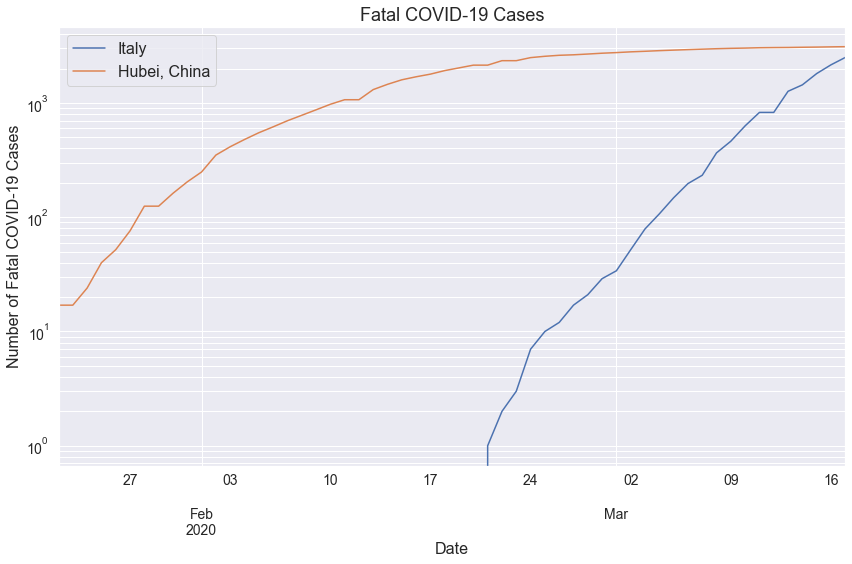

In [22]:
plot_covid_19_data_mpl(case_type='Fatal', locations=['Italy', 'Hubei, China'])

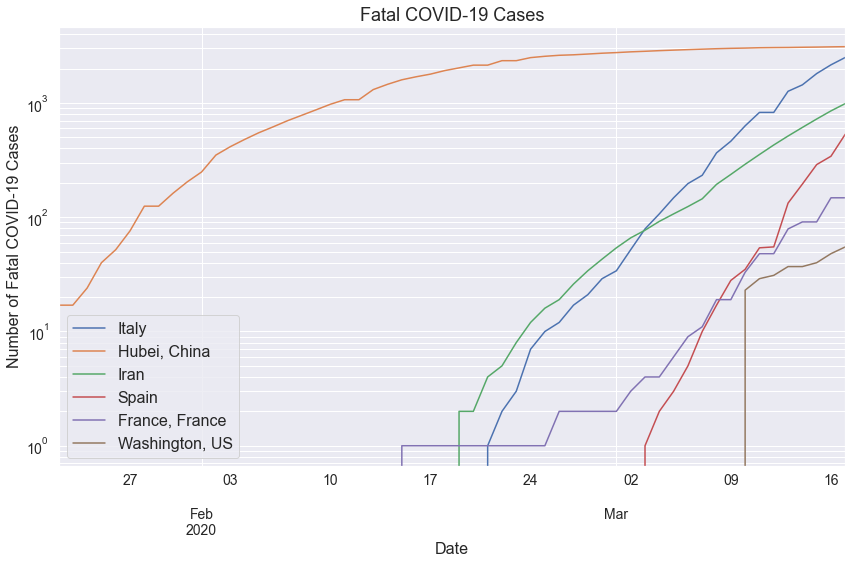

In [23]:
plot_covid_19_data_mpl(case_type='Fatal', locations=['Italy', 'Hubei, China', 'Iran', 'Spain', 'France, France', 'Washington, US'])

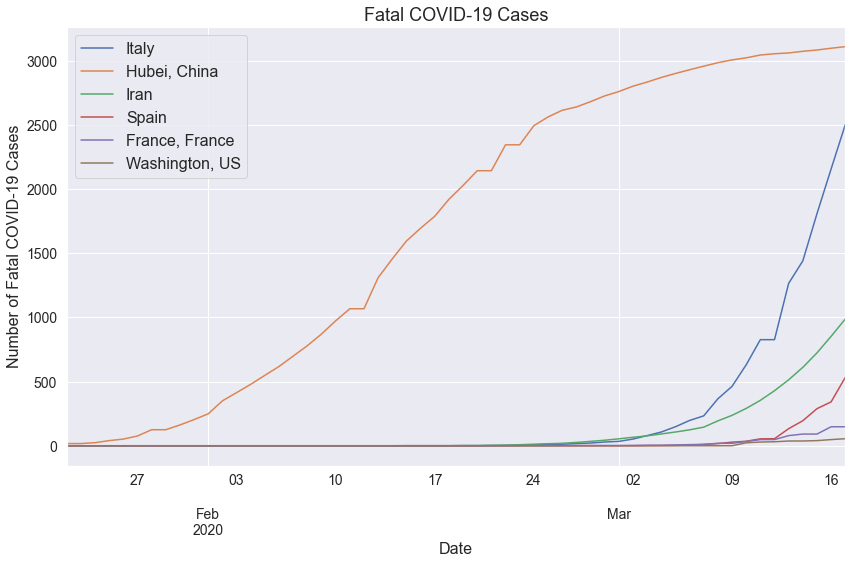

In [24]:
plot_covid_19_data_mpl(case_type='Fatal', locations=['Italy', 'Hubei, China', 'Iran', 'Spain', 'France, France',  'Washington, US'], y_type='linear')

In [20]:
def plot_covid_19_data_mpl(case_type='Fatal', locations=['Italy', 'Hubei, China'], y_type='log', figsize=(12,8)):
    if case_type.lower() == 'confirmed':
        df = confirmed_df
    elif case_type.lower() == 'recovered':
        df = recovered_df
    else:
        df = deaths_df
        
    fig, ax = plt.subplots(figsize=figsize)
    for location in locations:
        ax = df.plot(x='date', y=location, ax=ax)
    ax.set_yscale(y_type)
    ax.grid(b=True, which='both', axis='y')
    
    ax.set_title(f"{case_type} COVID-19 Cases", fontsize=18)
    ax.set_ylabel(f"Number of {case_type} COVID-19 Cases", fontsize=16)
    ax.set_xlabel('Date', fontsize=16)
    ax.legend(fontsize=16)
    ax.tick_params(which='both', labelsize=14)
    
    plt.tight_layout()

## Using Martin Barron's Illinois Data

In [25]:
il_covid_df = pd.read_csv('https://raw.githubusercontent.com/MartinLBarron/IllinoisCovid-19-tracking/master/data/IL-covid-19-cases.csv')

In [34]:
il_covid_df['Deaths'] = il_covid_df['Deaths'].fillna(0)
il_covid_df['Deaths'] = il_covid_df['Deaths'].astype(int)
il_covid_df['Date'] = pd.to_datetime(il_covid_df['Date'], format='%m/%d/%y')
il_covid_df['Events'] = il_covid_df['Events'].fillna('')

In [35]:
il_covid_df

,Date,Cases,Deaths,Events
0,2020-01-24,1,0,
1,2020-01-25,1,0,
2,2020-01-26,1,0,
3,2020-01-27,1,0,
4,2020-01-28,1,0,
5,2020-01-29,1,0,
6,2020-01-30,2,0,
7,2020-01-31,2,0,
8,2020-02-01,2,0,
9,2020-02-02,2,0,


In [40]:
def plot_IL_covid_19_data_mpl(y_type='log', df=il_covid_df, figsize=(12,8)):
    fig, ax = plt.subplots(figsize=figsize)
    for col in ['Cases', 'Deaths']:
        x = df.plot(x='Date', y=col, ax=ax)
    ax.set_yscale(y_type)
    ax.grid(b=True, which='both', axis='y')
    
    ax.set_title(f"Illinois COVID-19 Cases", fontsize=18)
    ax.set_ylabel(f"Number of Illinois COVID-19 Cases", fontsize=16)
    ax.set_xlabel('Date', fontsize=16)
    ax.legend(fontsize=16)
    ax.tick_params(which='both', labelsize=14)
    
    plt.tight_layout()

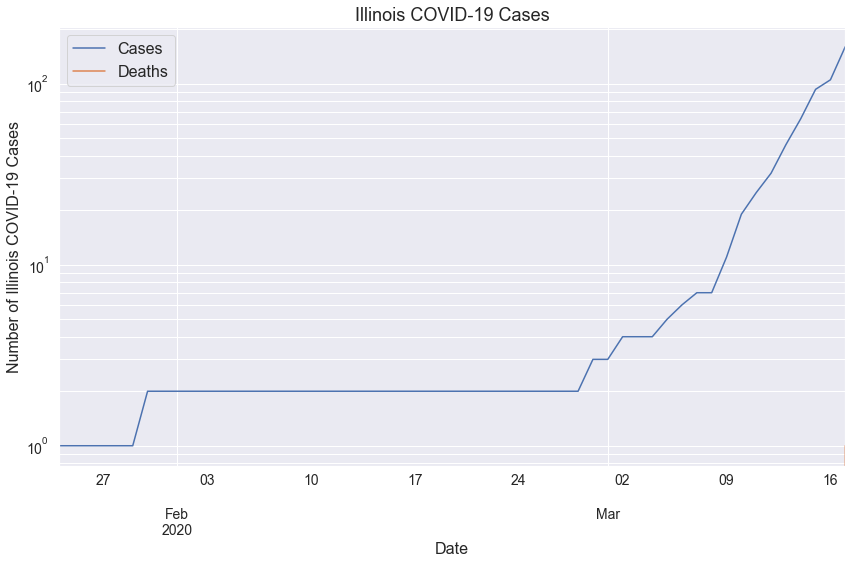

In [41]:
plot_IL_covid_19_data_mpl(y_type='log', df=il_covid_df, figsize=(12,8))

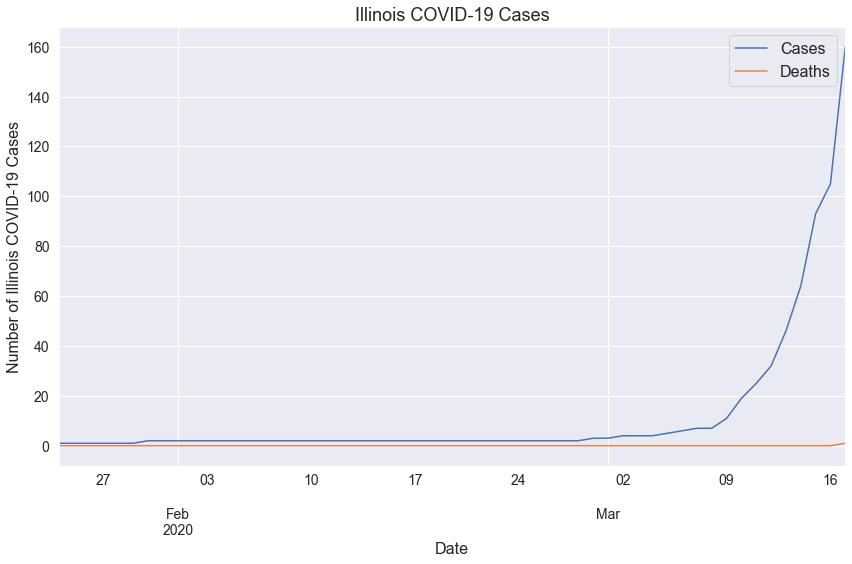

In [42]:
plot_IL_covid_19_data_mpl(y_type='linear', df=il_covid_df, figsize=(12,8))